In [1]:
import csv
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sqlite3
import pandas as pd

# Connect to the .db file
db_file = 'C:\\xuexi\\Anaconda\\RNA\\msigdb_v2024.1.Hs.db\\msigdb_v2024.1.Hs.db'  # Replace with your actual file name
conn = sqlite3.connect(db_file)

# Step 1: Validation query to get gene sets and their symbols
validation_query = """
SELECT 
    gs.standard_name AS STANDARD_NAME,
    GROUP_CONCAT(DISTINCT gsym.symbol) AS symbol
FROM gene_set gs
LEFT JOIN gene_set_gene_symbol gsgs ON gs.id = gsgs.gene_set_id
LEFT JOIN gene_symbol gsym ON gsgs.gene_symbol_id = gsym.id
GROUP BY gs.id, gs.standard_name
"""

# Step 2: Full query with all fields
query = """
SELECT 
    gs.standard_name AS STANDARD_NAME,
    gs.collection_name AS collection_name,
    p.PMID AS PMID,
    gsd.exact_source AS EXACT_SOURCE,
    gsd.description_brief AS DESCRIPTION_BRIEF,
    gsd.description_full AS DESCRIPTION_FULL,
    GROUP_CONCAT(DISTINCT gsym.symbol) AS symbol
FROM gene_set gs
LEFT JOIN gene_set_details gsd ON gs.id = gsd.gene_set_id
LEFT JOIN publication p ON gsd.publication_id = p.id
LEFT JOIN gene_set_gene_symbol gsgs ON gs.id = gsgs.gene_set_id
LEFT JOIN gene_symbol gsym ON gsgs.gene_symbol_id = gsym.id
GROUP BY gs.id, gs.standard_name, gs.collection_name, p.PMID, gsd.exact_source, 
         gsd.description_brief, gsd.description_full
"""

try:
    # Validate gene count for "AAACCAC_MIR140"
    df_validation = pd.read_sql_query(validation_query, conn)
    # Format symbols with ', ' separator
    df_validation['symbol'] = df_validation['symbol'].apply(lambda x: ', '.join(x.split(',')) if pd.notna(x) else '')
    aaaccac_row = df_validation[df_validation['STANDARD_NAME'] == 'AAACCAC_MIR140']
    if not aaaccac_row.empty:
        symbols = aaaccac_row['symbol'].iloc[0]
        gene_count = len(symbols.split(', ')) if symbols else 0
        print(f"Validation - AAACCAC_MIR140 has {gene_count} genes: {symbols[:100]}...")

    # Execute the full query
    df = pd.read_sql_query(query, conn)

    # Format symbols with ', ' separator
    df['symbol'] = df['symbol'].apply(lambda x: ', '.join(x.split(',')) if pd.notna(x) else '')

    # Add a column for gene count
    df['gene_count'] = df['symbol'].apply(lambda x: len(x.split(', ')) if x else 0)

    # Check the DataFrame
    print("\nDataFrame head:")
    print(df.head())
    print(f"Total gene sets: {len(df)}")

    # Check AAACCAC_MIR140 specifically
    aaaccac_full = df[df['STANDARD_NAME'] == 'AAACCAC_MIR140']
    if not aaaccac_full.empty:
        print("\nAAACCAC_MIR140 full row:")
        print(aaaccac_full)

    # Save to CSV
    output_file = 'gene_sets_extracted_fixed.csv'
    df.to_csv(output_file, index=False, encoding='utf-8')
    print(f"Data saved to '{output_file}'")

except sqlite3.Error as e:
    print(f"Database error: {e}")
except Exception as e:
    print(f"An error occurred: {e}")

# Clean up
conn.close()

Validation - AAACCAC_MIR140 has 110 genes: SLC25A13, RNF19A, CUL3, ATOSA, R3HDM1, COL23A1, EYA2, NAV3, HDAC4, TP53INP2, SENP1, OSTM1, STRADB, D...

DataFrame head:
           STANDARD_NAME    collection_name      PMID EXACT_SOURCE  \
0         AAACCAC_MIR140  C3:MIR:MIR_LEGACY      None         None   
1         AAAGACA_MIR511  C3:MIR:MIR_LEGACY      None         None   
2         AAAGGAT_MIR501  C3:MIR:MIR_LEGACY      None         None   
3  AAAGGGA_MIR204_MIR211  C3:MIR:MIR_LEGACY      None         None   
4      AAANWWTGC_UNKNOWN  C3:TFT:TFT_LEGACY  15735639         None   

                                   DESCRIPTION_BRIEF  \
0  Genes having at least one occurence of the mot...   
1  Genes having at least one occurence of the mot...   
2  Genes having at least one occurence of the mot...   
3  Genes having at least one occurence of the mot...   
4  Genes having at least one occurrence of the hi...   

                                    DESCRIPTION_FULL  \
0                     

In [11]:
df["collection_name"].value_counts()

collection_name
C5:GO:BP              7608
C5:HPO                5653
C7:IMMUNESIGDB        4872
C2:CGP                3494
C3:MIR:MIRDB          2377
C5:GO:MF              1820
C2:CP:REACTOME        1736
C5:GO:CC              1026
C8                     840
C2:CP:WIKIPATHWAYS     830
C2:CP:KEGG_MEDICUS     658
C3:TFT:TFT_LEGACY      610
C3:TFT:GTRD            505
C4:CM                  431
C4:CGN                 427
C7:VAX                 347
C1                     302
C2:CP:BIOCARTA         292
C3:MIR:MIR_LEGACY      221
C2:CP:PID              196
C6                     189
C2:CP:KEGG_LEGACY      186
C4:3CA                 148
H                       50
C2:CP                   19
Name: count, dtype: int64

In [12]:
dff = df.copy()
dff["collection"] = dff["collection_name"].str.lower()
dff["collection"] = dff["collection"].str.replace(":",".")
dff = dff.drop("collection_name", axis=1).set_index("STANDARD_NAME").reset_index()
dff = dff.rename(columns={"STANDARD_NAME":"Term"})

In [13]:
dff.head(2)

,Term,PMID,EXACT_SOURCE,DESCRIPTION_BRIEF,DESCRIPTION_FULL,symbol,gene_count,collection
0,AAACCAC_MIR140,None,None,Genes having at least one occurence of the mot...,None,"SLC25A13, RNF19A, CUL3, ATOSA, R3HDM1, COL23A1...",110,c3.mir.mir_legacy
1,AAAGACA_MIR511,None,None,Genes having at least one occurence of the mot...,None,"ENPP4, REV3L, NRXN3, RNF19A, ADSS2, FOXN3, TRA...",204,c3.mir.mir_legacy


In [5]:
df_24_collection = pd.read_csv("C:\\xuexi\\Anaconda\\RNA\\msigdb\\24_collection.csv",index_col=0)
df_24_collection["collection"] = df_24_collection["collection"].str.lower()
df_24_collection.tail(2)

,collection,sets_number,Term,RFE_NES,RFE_q_val,Original_NES,Original_q_val,Diff_NES,Diff_FDR_q_val,only by RFE,by_rfe,only by original,by_original,by two methods,"Highlighted by two methods\nNES,FDR_q_val both improved\n(418)","NES,FDR_q_val both improved\n(column L+P = 611)",number
Total #,,,,,,,,,,,,,,,,,
16,hallmark,50,HALLMARK_INFLAMMATORY_RESPONSE,NaN,NaN,1.57,0.05,NaN,NaN,False,False,True,True,False,False,False,1
17,hallmark,50,HALLMARK_MYOGENESIS,NaN,NaN,1.70,0.03,NaN,NaN,False,False,True,True,False,False,False,1


In [ ]:
len(df_24_collection)

In [44]:
df_24_all = df_24_collection.merge(dff[["Term","PMID","DESCRIPTION_BRIEF","DESCRIPTION_FULL","symbol"]],on="Term",how="left")
df_24_all.tail(2)

,collection,sets_number,Term,RFE_NES,RFE_q_val,Original_NES,Original_q_val,Diff_NES,Diff_FDR_q_val,only by RFE,...,only by original,by_original,by two methods,"Highlighted by two methods\nNES,FDR_q_val both improved\n(418)","NES,FDR_q_val both improved\n(column L+P = 611)",number,PMID,DESCRIPTION_BRIEF,DESCRIPTION_FULL,symbol
1568,hallmark,50,HALLMARK_INFLAMMATORY_RESPONSE,NaN,NaN,1.57,0.05,NaN,NaN,False,...,True,True,False,False,False,1,26771021,Genes defining inflammatory response.,None,"SLC7A2, STAB1, ATP2C1, KIF1B, DCBLD2, MXD1, GN..."
1569,hallmark,50,HALLMARK_MYOGENESIS,NaN,NaN,1.70,0.03,NaN,NaN,False,...,True,True,False,False,False,1,26771021,Genes involved in development of skeletal musc...,None,"IFRD1, FHL1, GABARAPL2, DAPK2, KCNH2, CAMK2B, ..."


In [45]:
gene_set_number = df_24_all[["collection","sets_number"]].drop_duplicates(subset=["collection"]).reset_index(drop=True)
gene_set_number

,collection,sets_number
0,c1.all,302
1,c2.cpg,3494
2,c2.cp.biocarta,292
3,c2.cp.kegg_medicus,658
4,c2.cp.pid,196
5,c2.cp.reactome,1736
6,c2.cp.wikipathways,830
7,c2.cp.kegg_legacy,186
8,c3.mir.mirdb,2377
9,c3.mir.mir_legacy,221


In [9]:
gene_set_number["sets_number"].sum()

34818

In [10]:
df_24_all.columns

Index(['collection', 'sets_number', 'Term', 'RFE_NES', 'RFE_q_val',
       'Original_NES', 'Original_q_val', 'Diff_NES', 'Diff_FDR_q_val',
       'only by RFE ', 'by_rfe', 'only  by original', 'by_original',
       'by two methods',
       'Highlighted by two methods\nNES,FDR_q_val both improved\n(418)',
       'NES,FDR_q_val both improved\n(column L+P = 611)', 'number', 'PMID',
       'DESCRIPTION_BRIEF', 'DESCRIPTION_FULL', 'symbol'],
      dtype='object')

In [46]:
query_words = ["RUVBL","chromatin remodeling","chromatin accessibility","multiple myeloma",
               "lymphoma","hematology","hematological cancer","bone marrow", 
               "chromatin", "myeloma", "lymph", "hema", "marrow"]

def assignrow(text, word):
    if pd.isna(text):  # Handle NaN values
        return 0
    return 1 if word.lower() in str(text).lower() else 0

In [47]:
for word in query_words:
    df_24_all[word] = df_24_all.apply(lambda row: max(assignrow(row['DESCRIPTION_BRIEF'], word), assignrow(row['DESCRIPTION_FULL'], word)), axis=1)


In [48]:
df_24_all.head(2)

,collection,sets_number,Term,RFE_NES,RFE_q_val,Original_NES,Original_q_val,Diff_NES,Diff_FDR_q_val,only by RFE,...,lymphoma,hematology,hematological cancer,bone marrow,RUVBL,chromatin,myeloma,lymph,hema,marrow
0,c1.all,302,chr12q13,-2.35,0.01,NaN,NaN,NaN,NaN,True,...,0,0,0,0,0,0,0,0,0,0
1,c1.all,302,chr16q22,2.16,0.05,NaN,NaN,NaN,NaN,True,...,0,0,0,0,0,0,0,0,0,0


In [49]:
def isrelated(row):
    if row[-14:].sum() == 0:
        return 0
    else:
        return 1

In [50]:
df_24_all["is_related"] = df_24_all.apply(lambda row:isrelated(row),axis=1 )

In [52]:
df_24_all.to_csv("C:\\xuexi\\Anaconda\\RNA\\msigdb\\24_collection_big_table_14words.csv")

In [51]:
df_24_all.head(2)

,collection,sets_number,Term,RFE_NES,RFE_q_val,Original_NES,Original_q_val,Diff_NES,Diff_FDR_q_val,only by RFE,...,hematology,hematological cancer,bone marrow,RUVBL,chromatin,myeloma,lymph,hema,marrow,is_related
0,c1.all,302,chr12q13,-2.35,0.01,NaN,NaN,NaN,NaN,True,...,0,0,0,0,0,0,0,0,0,0
1,c1.all,302,chr16q22,2.16,0.05,NaN,NaN,NaN,NaN,True,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# all_24_counts = pd.DataFrame(df_24_all["collection"].value_counts()).reset_index()
# all_24_counts = all_24_counts.sort_values(by="collection").reset_index(drop=True)
# all_24_counts 

In [53]:
df_24_all.groupby(["collection"]).is_related.sum().reset_index()

,collection,is_related
0,c1.all,0
1,c2.cp.biocarta,1
2,c2.cp.kegg_legacy,0
3,c2.cp.kegg_medicus,0
4,c2.cp.pid,0
5,c2.cp.reactome,1
6,c2.cp.wikipathways,0
7,c2.cpg,103
8,c3.mir.mir_legacy,0
9,c3.mir.mirdb,0


In [ ]:
# df_only_original = df_24_all[df_24_all["only highlighted by original"]==True]
# df_only_original

In [ ]:
all_data

In [54]:
all_data = pd.DataFrame(df_24_all.pivot_table(index=["collection"],values=['number', 'is_related'], aggfunc=np.sum)).reset_index()
all_data = gene_set_number.merge(all_data,on="collection",how="left")
all_data.columns = ["collection","sets_number","all_related","total"]
all_data["ratio_relevant_all"] = round(all_data["all_related"].div(all_data["total"], fill_value=0),3)
all_data["ratio_2_all"] = round(all_data["total"].div(all_data["sets_number"], fill_value=0),3)
# all_data = all_data.set_index("collection")
all_data

C:\Users\weiju\AppData\Local\Temp\ipykernel_22748\20202606.py:1: FutureWarning: The provided callable <function sum at 0x000001AF965DB9A0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  all_data = pd.DataFrame(df_24_all.pivot_table(index=["collection"],values=['number', 'is_related'], aggfunc=np.sum)).reset_index()


,collection,sets_number,all_related,total,ratio_relevant_all,ratio_2_all
0,c1.all,302,0,2,0.000,0.007
1,c2.cpg,3494,103,386,0.267,0.110
2,c2.cp.biocarta,292,1,2,0.500,0.007
3,c2.cp.kegg_medicus,658,0,13,0.000,0.020
4,c2.cp.pid,196,0,4,0.000,0.020
5,c2.cp.reactome,1736,1,90,0.011,0.052
6,c2.cp.wikipathways,830,0,28,0.000,0.034
7,c2.cp.kegg_legacy,186,0,12,0.000,0.065
8,c3.mir.mirdb,2377,0,5,0.000,0.002
9,c3.mir.mir_legacy,221,0,1,0.000,0.005


In [56]:
df_24_all.columns

Index(['collection', 'sets_number', 'Term', 'RFE_NES', 'RFE_q_val',
       'Original_NES', 'Original_q_val', 'Diff_NES', 'Diff_FDR_q_val',
       'only by RFE ', 'by_rfe', 'only  by original', 'by_original',
       'by two methods',
       'Highlighted by two methods\nNES,FDR_q_val both improved\n(418)',
       'NES,FDR_q_val both improved\n(column L+P = 611)', 'number', 'PMID',
       'DESCRIPTION_BRIEF', 'DESCRIPTION_FULL', 'symbol', 'RUBVL',
       'chromatin remodeling', 'chromatin accessibility', 'multiple myeloma',
       'lymphoma', 'hematology', 'hematological cancer', 'bone marrow',
       'RUVBL', 'chromatin', 'myeloma', 'lymph', 'hema', 'marrow',
       'is_related'],
      dtype='object')

In [55]:
df_only_RFE = df_24_all[df_24_all["only by RFE "]==True]
df_only_RFE = pd.DataFrame(df_only_RFE.pivot_table(index=["collection"],values=['number', 'is_related'], aggfunc=np.sum)).reset_index()
df_only_RFE = gene_set_number.merge(df_only_RFE,on="collection",how="left")
df_only_RFE.columns = ["collection","sets_number","only_rfe_related","only_rfe_#"]
df_only_RFE["ratio_relevant_only_rfe"] = round(df_only_RFE["only_rfe_related"].div(df_only_RFE["only_rfe_#"], fill_value=0),3)
df_only_RFE["ratio_2_only_rfe"] = round(df_only_RFE["only_rfe_#"].div(df_only_RFE["sets_number"], fill_value=0),3)
df_only_RFE = df_only_RFE.drop(["sets_number"],axis=1)
df_only_RFE

C:\Users\weiju\AppData\Local\Temp\ipykernel_22748\1149549146.py:2: FutureWarning: The provided callable <function sum at 0x000001AF965DB9A0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_only_RFE = pd.DataFrame(df_only_RFE.pivot_table(index=["collection"],values=['number', 'is_related'], aggfunc=np.sum)).reset_index()


,collection,only_rfe_related,only_rfe_#,ratio_relevant_only_rfe,ratio_2_only_rfe
0,c1.all,0.0,2.0,0.000,0.007
1,c2.cpg,21.0,63.0,0.333,0.018
2,c2.cp.biocarta,NaN,NaN,NaN,0.000
3,c2.cp.kegg_medicus,0.0,1.0,0.000,0.002
4,c2.cp.pid,NaN,NaN,NaN,0.000
5,c2.cp.reactome,0.0,5.0,0.000,0.003
6,c2.cp.wikipathways,0.0,9.0,0.000,0.011
7,c2.cp.kegg_legacy,0.0,1.0,0.000,0.005
8,c3.mir.mirdb,NaN,NaN,NaN,0.000
9,c3.mir.mir_legacy,NaN,NaN,NaN,0.000


In [57]:
df_by_rfe = df_24_all[df_24_all["by_rfe"]==True]
df_by_rfe = pd.DataFrame(df_by_rfe.pivot_table(index=["collection"],values=['number', 'is_related'], aggfunc=np.sum)).reset_index()
df_by_rfe = gene_set_number.merge(df_by_rfe,on="collection",how="left")
df_by_rfe.columns = ["collection","sets_number","by_rfe_related","by_rfe_#"]
df_by_rfe["ratio_relevant_by_rfe"] = round(df_by_rfe["by_rfe_related"].div(df_by_rfe["by_rfe_#"], fill_value=0),3)
df_by_rfe["ratio_2_rfe"] = round(df_by_rfe["by_rfe_#"].div(df_by_rfe["sets_number"], fill_value=0),3)
df_by_rfe = df_by_rfe.drop(["sets_number"],axis=1)
df_by_rfe

C:\Users\weiju\AppData\Local\Temp\ipykernel_22748\3190917400.py:2: FutureWarning: The provided callable <function sum at 0x000001AF965DB9A0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_by_rfe = pd.DataFrame(df_by_rfe.pivot_table(index=["collection"],values=['number', 'is_related'], aggfunc=np.sum)).reset_index()


,collection,by_rfe_related,by_rfe_#,ratio_relevant_by_rfe,ratio_2_rfe
0,c1.all,0.0,2.0,0.000,0.007
1,c2.cpg,77.0,256.0,0.301,0.073
2,c2.cp.biocarta,NaN,NaN,NaN,0.000
3,c2.cp.kegg_medicus,0.0,4.0,0.000,0.006
4,c2.cp.pid,0.0,2.0,0.000,0.010
5,c2.cp.reactome,1.0,47.0,0.021,0.027
6,c2.cp.wikipathways,0.0,20.0,0.000,0.024
7,c2.cp.kegg_legacy,0.0,4.0,0.000,0.022
8,c3.mir.mirdb,NaN,NaN,NaN,0.000
9,c3.mir.mir_legacy,NaN,NaN,NaN,0.000


In [58]:
df_only_original = df_24_all[df_24_all["only  by original"]==True]
df_only_original = pd.DataFrame(df_only_original.pivot_table(index=["collection"],values=['number', 'is_related'], aggfunc=np.sum)).reset_index()
df_only_original = gene_set_number.merge(df_only_original,on="collection",how="left")
df_only_original.columns = ["collection","sets_number","only_original_related","only_original_#"]
df_only_original["ratio_relevant_only_original"] = round(df_only_original["only_original_related"].div(df_only_original["only_original_#"], fill_value=0),3)
df_only_original["ratio_2_only_original"] = round(df_only_original["only_original_#"].div(df_only_original["sets_number"], fill_value=0),3)
df_only_original = df_only_original.drop(["sets_number"],axis=1)
df_only_original

C:\Users\weiju\AppData\Local\Temp\ipykernel_22748\586555033.py:2: FutureWarning: The provided callable <function sum at 0x000001AF965DB9A0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_only_original = pd.DataFrame(df_only_original.pivot_table(index=["collection"],values=['number', 'is_related'], aggfunc=np.sum)).reset_index()


,collection,only_original_related,only_original_#,ratio_relevant_only_original,ratio_2_only_original
0,c1.all,NaN,NaN,NaN,0.000
1,c2.cpg,26.0,130.0,0.200,0.037
2,c2.cp.biocarta,1.0,2.0,0.500,0.007
3,c2.cp.kegg_medicus,0.0,9.0,0.000,0.014
4,c2.cp.pid,0.0,2.0,0.000,0.010
5,c2.cp.reactome,0.0,43.0,0.000,0.025
6,c2.cp.wikipathways,0.0,8.0,0.000,0.010
7,c2.cp.kegg_legacy,0.0,8.0,0.000,0.043
8,c3.mir.mirdb,0.0,5.0,0.000,0.002
9,c3.mir.mir_legacy,0.0,1.0,0.000,0.005


In [59]:
df_by_original = df_24_all[df_24_all["by_original"]==True]
df_by_original = pd.DataFrame(df_by_original.pivot_table(index=["collection"],values=['number', 'is_related'], aggfunc=np.sum)).reset_index()
df_by_original = gene_set_number.merge(df_by_original,on="collection",how="left")
df_by_original.columns = ["collection","sets_number","by_original_related","by_original_#"]
df_by_original["ratio_relevant_by_original"] = round(df_by_original["by_original_related"].div(df_by_original["by_original_#"], fill_value=0),3)
df_by_original["ratio_2_original"] = round(df_by_original["by_original_#"].div(df_by_original["sets_number"], fill_value=0),3)
df_by_original = df_by_original.drop(["sets_number"],axis=1)
df_by_original

C:\Users\weiju\AppData\Local\Temp\ipykernel_22748\3199327574.py:2: FutureWarning: The provided callable <function sum at 0x000001AF965DB9A0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_by_original = pd.DataFrame(df_by_original.pivot_table(index=["collection"],values=['number', 'is_related'], aggfunc=np.sum)).reset_index()


,collection,by_original_related,by_original_#,ratio_relevant_by_original,ratio_2_original
0,c1.all,NaN,NaN,NaN,0.000
1,c2.cpg,82.0,323.0,0.254,0.092
2,c2.cp.biocarta,1.0,2.0,0.500,0.007
3,c2.cp.kegg_medicus,0.0,12.0,0.000,0.018
4,c2.cp.pid,0.0,4.0,0.000,0.020
5,c2.cp.reactome,1.0,85.0,0.012,0.049
6,c2.cp.wikipathways,0.0,19.0,0.000,0.023
7,c2.cp.kegg_legacy,0.0,11.0,0.000,0.059
8,c3.mir.mirdb,0.0,5.0,0.000,0.002
9,c3.mir.mir_legacy,0.0,1.0,0.000,0.005


In [60]:
df_by_two = df_24_all[df_24_all["by two methods"]==True]
df_by_two = pd.DataFrame(df_by_two.pivot_table(index=["collection"],values=['number', 'is_related'], aggfunc=np.sum)).reset_index()
df_by_two = gene_set_number.merge(df_by_two,on="collection",how="left")
df_by_two.columns = ["collection","sets_number","tow_related","two_methods_#"]
df_by_two["ratio_relevant_by_two"] = round(df_by_two["tow_related"].div(df_by_two["two_methods_#"], fill_value=0),3)
df_by_two["ratio_2_two"] = round(df_by_two["two_methods_#"].div(df_by_two["sets_number"], fill_value=0),3)
df_by_two = df_by_two.drop(["sets_number"],axis=1)
df_by_two

C:\Users\weiju\AppData\Local\Temp\ipykernel_22748\2360809671.py:2: FutureWarning: The provided callable <function sum at 0x000001AF965DB9A0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df_by_two = pd.DataFrame(df_by_two.pivot_table(index=["collection"],values=['number', 'is_related'], aggfunc=np.sum)).reset_index()


,collection,tow_related,two_methods_#,ratio_relevant_by_two,ratio_2_two
0,c1.all,NaN,NaN,NaN,0.000
1,c2.cpg,56.0,193.0,0.290,0.055
2,c2.cp.biocarta,NaN,NaN,NaN,0.000
3,c2.cp.kegg_medicus,0.0,3.0,0.000,0.005
4,c2.cp.pid,0.0,2.0,0.000,0.010
5,c2.cp.reactome,1.0,42.0,0.024,0.024
6,c2.cp.wikipathways,0.0,11.0,0.000,0.013
7,c2.cp.kegg_legacy,0.0,3.0,0.000,0.016
8,c3.mir.mirdb,NaN,NaN,NaN,0.000
9,c3.mir.mir_legacy,NaN,NaN,NaN,0.000


In [61]:
df_whole_table = all_data.merge(df_only_original,on="collection",how="left").merge(df_by_original,on="collection",how="left").merge(df_only_RFE,on="collection",how="left").merge(df_by_rfe,on="collection",how="left").merge(df_by_two,on="collection",how="left").reset_index(drop=True)
df_whole_table

,collection,sets_number,all_related,total,ratio_relevant_all,ratio_2_all,only_original_related,only_original_#,ratio_relevant_only_original,ratio_2_only_original,...,ratio_relevant_only_rfe,ratio_2_only_rfe,by_rfe_related,by_rfe_#,ratio_relevant_by_rfe,ratio_2_rfe,tow_related,two_methods_#,ratio_relevant_by_two,ratio_2_two
0,c1.all,302,0,2,0.000,0.007,NaN,NaN,NaN,0.000,...,0.000,0.007,0.0,2.0,0.000,0.007,NaN,NaN,NaN,0.000
1,c2.cpg,3494,103,386,0.267,0.110,26.0,130.0,0.200,0.037,...,0.333,0.018,77.0,256.0,0.301,0.073,56.0,193.0,0.290,0.055
2,c2.cp.biocarta,292,1,2,0.500,0.007,1.0,2.0,0.500,0.007,...,NaN,0.000,NaN,NaN,NaN,0.000,NaN,NaN,NaN,0.000
3,c2.cp.kegg_medicus,658,0,13,0.000,0.020,0.0,9.0,0.000,0.014,...,0.000,0.002,0.0,4.0,0.000,0.006,0.0,3.0,0.000,0.005
4,c2.cp.pid,196,0,4,0.000,0.020,0.0,2.0,0.000,0.010,...,NaN,0.000,0.0,2.0,0.000,0.010,0.0,2.0,0.000,0.010
5,c2.cp.reactome,1736,1,90,0.011,0.052,0.0,43.0,0.000,0.025,...,0.000,0.003,1.0,47.0,0.021,0.027,1.0,42.0,0.024,0.024
6,c2.cp.wikipathways,830,0,28,0.000,0.034,0.0,8.0,0.000,0.010,...,0.000,0.011,0.0,20.0,0.000,0.024,0.0,11.0,0.000,0.013
7,c2.cp.kegg_legacy,186,0,12,0.000,0.065,0.0,8.0,0.000,0.043,...,0.000,0.005,0.0,4.0,0.000,0.022,0.0,3.0,0.000,0.016
8,c3.mir.mirdb,2377,0,5,0.000,0.002,0.0,5.0,0.000,0.002,...,NaN,0.000,NaN,NaN,NaN,0.000,NaN,NaN,NaN,0.000
9,c3.mir.mir_legacy,221,0,1,0.000,0.005,0.0,1.0,0.000,0.005,...,NaN,0.000,NaN,NaN,NaN,0.000,NaN,NaN,NaN,0.000


In [62]:
df_whole_table["collection"] = df_whole_table["collection"]+" ("+df_whole_table["sets_number"].astype(str)+")"

In [63]:
df_whole_table.head(2)

,collection,sets_number,all_related,total,ratio_relevant_all,ratio_2_all,only_original_related,only_original_#,ratio_relevant_only_original,ratio_2_only_original,...,ratio_relevant_only_rfe,ratio_2_only_rfe,by_rfe_related,by_rfe_#,ratio_relevant_by_rfe,ratio_2_rfe,tow_related,two_methods_#,ratio_relevant_by_two,ratio_2_two
0,c1.all (302),302,0,2,0.000,0.007,NaN,NaN,NaN,0.000,...,0.000,0.007,0.0,2.0,0.000,0.007,NaN,NaN,NaN,0.000
1,c2.cpg (3494),3494,103,386,0.267,0.110,26.0,130.0,0.2,0.037,...,0.333,0.018,77.0,256.0,0.301,0.073,56.0,193.0,0.29,0.055


In [64]:
df_whole_table.to_csv("C:\\xuexi\\Anaconda\\RNA\\msigdb\\24_collection_counts_whole_table_14words.csv")

In [29]:
def barplot(dff,counts,ratio,title):
    # Set the figure size for better readability
    plt.figure(figsize=(12, 6))
    
    # Create the bar plot with collection names as x-axis and ratio as y-axis
    bars = plt.bar(dff["collection"], dff[ratio], color='skyblue')

    # Label each bar with the corresponding count value
    for bar, count in zip(bars, dff[counts]):
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # x position: center of the bar
            bar.get_height(),                   # y position: top of the bar
            str(count),                         # text: the count value
            ha='center', va='bottom'            # alignment
        )

    # Add labels and title
    plt.xlabel("Collection Name")
    plt.ylabel("Ratio")
    plt.title(title)
    plt.xticks(rotation=85)  # Rotate x-axis labels for better readability

    # Adjust layout to make room for rotated labels
    plt.tight_layout()

    # Display the plot
    plt.show()

In [30]:
df_whole_table.columns

Index(['collection', 'sets_number', 'all_related', 'total',
       'ratio_relevant_all', 'ratio_2_all', 'only_original_related',
       'only_original_#', 'ratio_relevant_only_original',
       'ratio_2_only_original', 'by_original_related', 'by_original_#',
       'ratio_relevant_by_original', 'ratio_2_original', 'only_rfe_related',
       'only_rfe_#', 'ratio_relevant_only_rfe', 'ratio_2_only_rfe',
       'by_rfe_related', 'by_rfe_#', 'ratio_relevant_by_rfe', 'ratio_2_rfe',
       'tow_related', 'two_methods_#', 'ratio_relevant_by_two', 'ratio_2_two'],
      dtype='object')

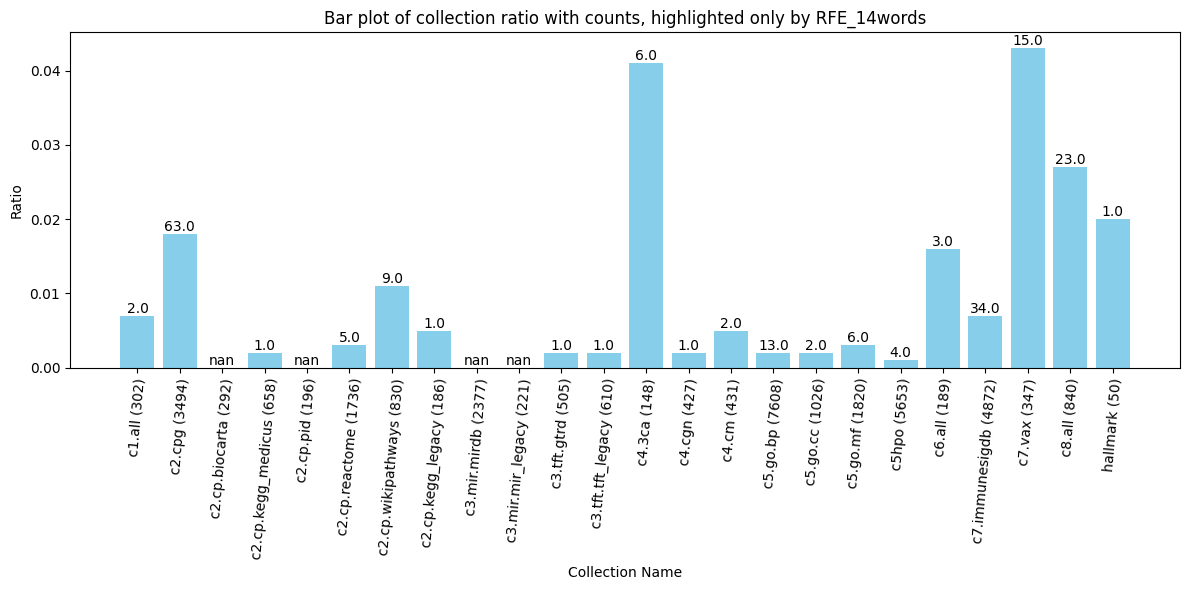

In [65]:
df_only_by_rfe = df_whole_table[["collection","only_rfe_#","ratio_2_only_rfe"]]
barplot(df_only_by_rfe,"only_rfe_#","ratio_2_only_rfe","Bar plot of collection ratio with counts, highlighted only by RFE_14words")

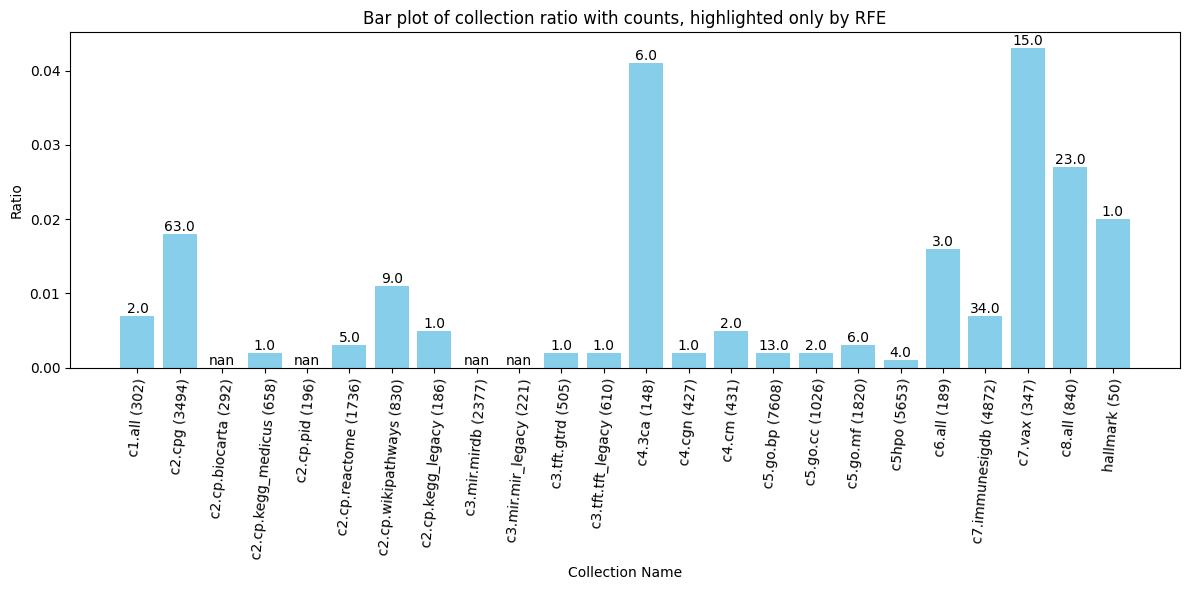

In [31]:
df_only_by_rfe = df_whole_table[["collection","only_rfe_#","ratio_2_only_rfe"]]
barplot(df_only_by_rfe,"only_rfe_#","ratio_2_only_rfe","Bar plot of collection ratio with counts, highlighted only by RFE")

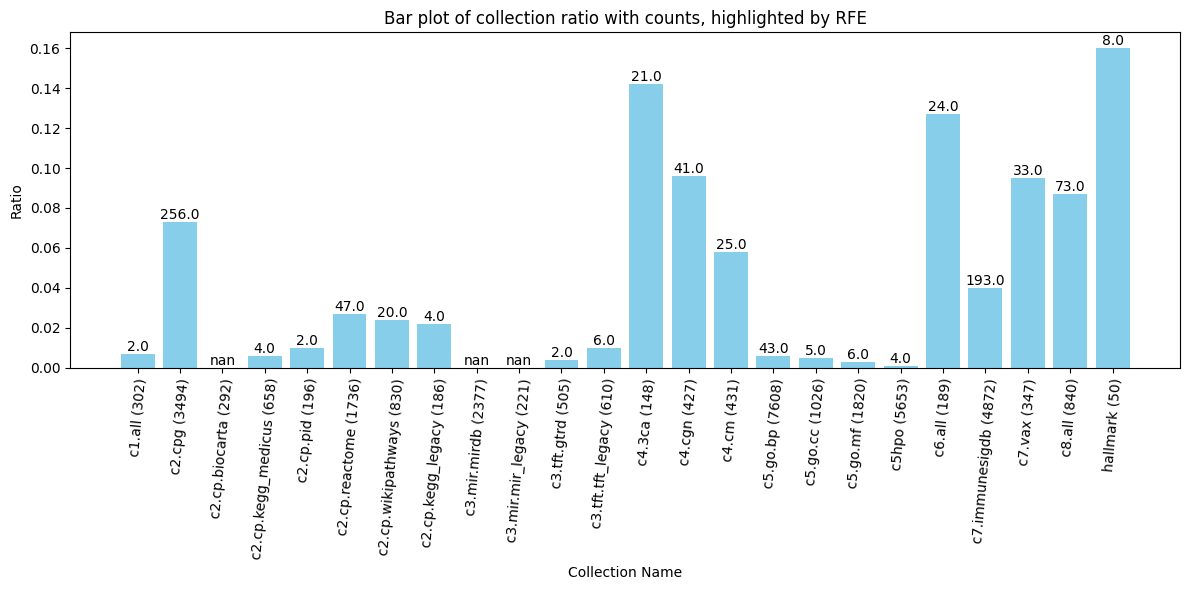

In [32]:
df_by_rfe = df_whole_table[["collection","by_rfe_#","ratio_2_rfe"]]
barplot(df_by_rfe,"by_rfe_#","ratio_2_rfe","Bar plot of collection ratio with counts, highlighted by RFE")